## Exercise 4 - Transmon qubit

### Importing Packages

In [46]:
# Import helper module from local folder
import sys
import os
sys.path.append(os.getcwd()) 
from resources import helper

# Numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt

# Import SI unit conversion factors
from resources.helper import GHz, MHz, kHz, us, ns
# Importing standard Qiskit libraries
from qiskit import IBMQ
from qiskit.tools.jupyter import *

from qiskit import pulse
from qiskit.pulse import Play, Schedule, DriveChannel
from qiskit.pulse import DriveChannel, Gaussian
from qiskit.tools.monitor import job_monitor
from resources.helper import SpecFitter
from qc_grader import grade_ex4

#### Account Setting

In [26]:
# Loading your IBM Quantum account
IBMQ.load_account()
IBMQ.providers() # see a list of providers you have access to

ibmqfactory.load_account:WARNING:2021-05-27 11:44:52,487: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='iqc2021-4', group='challenge-124', project='ex4')>]

In [27]:
# Get the special provider assigned to you using information from the output above
hub_name = 'iqc2021-4' # e.g. 'iqc2021-1'
group_name = 'challenge-124' # e.g. 'challenge-1'
project_name = 'ex4' # Your project name should be 'ex4'
provider = IBMQ.get_provider(hub=hub_name, group=group_name, project=project_name)

# Get `ibmq_jakarta` backend from the provider
backend_name = 'ibmq_jakarta'
backend = provider.get_backend(backend_name)
backend # See details of the `ibmq_jakarta` quantum system

<IBMQBackend('ibmq_jakarta') from IBMQ(hub='iqc2021-4', group='challenge-124', project='ex4')>

#### --------------------------------------------------------------------------------------------------------------------

## 1. Instantiate channels and retrieve measurement schedule

We will use the same measurement schedule throughout, whereas the drive schedules will vary. For any backend, we can ask for its default measurement pulse instead of calibrating it separately.

In [28]:
# Please use qubit 0 throughout the notebook
qubit = 0

Next, save the backend configuration and the sampling time $dt$. We will exclude the `AcquireChannel`s when plotting for clarity.

In [29]:
backend_config = backend.configuration()
exc_chans = helper.get_exc_chans(globals())
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.2222222222222222 ns


The `instruction_schedule_map` provides the parameters of the default calibrated pulses used by the backend. In particular, we see that this "native gate set" consists of a subset of operations you can perform on a [`QuantumCircuit`](https://qiskit.org/documentation/apidoc/circuit.html#gates-and-instructions), and is the gate set that the `QuantumCircuit` is transpiled to by Qiskit. 

In [30]:
backend_defaults = backend.defaults()
center_frequency = backend_defaults.qubit_freq_est
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

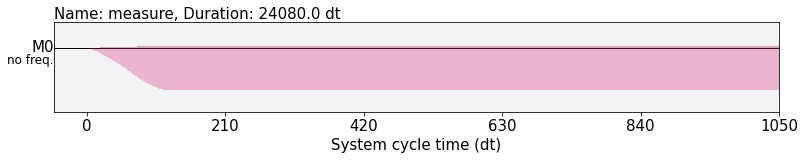

In [31]:
# Retrieve calibrated measurement pulse from backend
meas = inst_sched_map.get('measure', qubits=[qubit])
meas.exclude(channels=exc_chans).draw(time_range=[0,1000])

In [32]:
asl = inst_sched_map.get('measure', qubits=[qubit]).duration
asl

24080

### 1. |0> - |1>

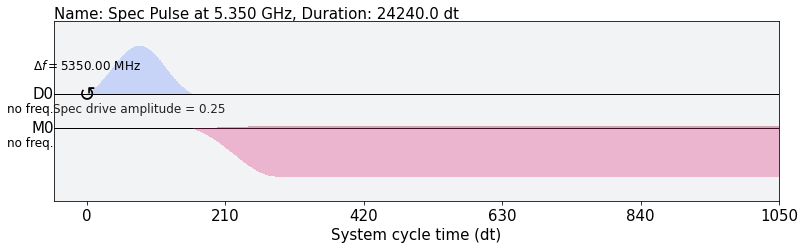

In [33]:
# The same spec pulse for both 01 and 12 spec
drive_amp = 0.25
drive_duration = inst_sched_map.get('x', qubits=[qubit]).duration

# Calibrated backend pulse use advanced DRAG pulse to reduce leakage to the |2> state.
# Here we will use simple Gaussian pulse

drive_sigma = drive_duration // 4 # DRAG pulses typically 4*sigma long. 
spec_pulse = Gaussian(duration=drive_duration, amp=drive_amp, 
                        sigma=drive_sigma, name=f"Spec drive amplitude = {drive_amp}")

# Construct an np array of the frequencies for our experiment
spec_freqs_GHz = helper.get_spec01_freqs(center_frequency, qubit)

# Create the base schedule
# Start with drive pulse acting on the drive channel
spec01_scheds = []
for freq in spec_freqs_GHz:
    with pulse.build(name="Spec Pulse at %.3f GHz" % freq) as spec01_sched:
        with pulse.align_sequential():
            # Pay close attention to this part to solve the problem at the end
            pulse.set_frequency(freq*GHz, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(meas)
            
    spec01_scheds.append(spec01_sched)

# Draw spec01 schedule
spec01_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [34]:
from qiskit.tools.monitor import job_monitor

# Run the job on a real backend
spec01_job = backend.run(spec01_scheds, job_name="Spec 01", **helper.job_params) 

print(spec01_job.job_id())
job_monitor(spec01_job)

# If the queuing time is too long, you can save the job id 
# And retrieve the job after it's done
# Replace 'JOB_ID' with the the your job id and uncomment to line below
#spec01_job = backend.retrieve_job('JOB_ID')

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60af863b4a088c0c25c51c5b
Job Status: job has successfully run


### Fit the Spectroscopy Data

We will fit the spectroscopy signal to a *Lorentzian* function of the form

$$ \frac{AB}{\pi[(f-f_{01})^2 + B^2]} + C $$

to find the qubit frequency $f_{01}$ with these fitting parameters:


Parameter | Corresponds to
 --- | ---
 $A$ | amplitude
 $f_{01}$ | 01 frequency guess (GHz)
 $B$ | scale
 $C$ | offset

 
 We will use the `SpecFitter` from the `helper` module that is based on the fitters from `qiskit.ignis.characterization.fitters` library.
 
<div class="alert alert-block alert-danger">

**Note:** You may need to modify the fitting parameters below to get a good fit.

</div>

Spec01 frequency is 5.236910 GHz


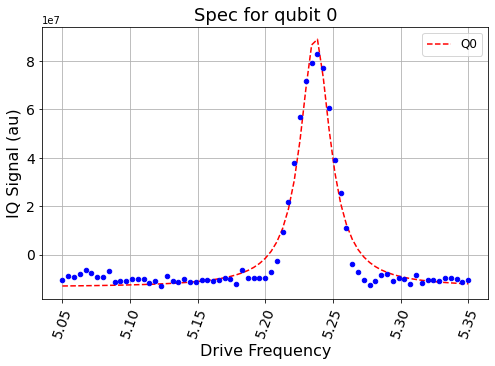

In [35]:
from resources.helper import SpecFitter

amp_guess = 5e6
f01_guess = 5
B = 1
C = 0
fit_guess = [amp_guess, f01_guess, B, C]

fit = SpecFitter(spec01_job.result(), spec_freqs_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f01 = fit.spec_freq(0, series='z')
print("Spec01 frequency is %.6f GHz" % f01)

Let's compare your result with the calibrated qubit frequency from the backend! If things are working properly, your result should be very close to the calibrated value ($\pm$1 MHz).

In [36]:
# Retrieve qubit frequency from backend properties
f01_calibrated = backend.properties().frequency(qubit) / GHz 
f01_error = abs(f01-f01_calibrated) * 1000 # error in MHz
print("Qubit frequency error is %.6f MHz" % f01_error) 

Qubit frequency error is 0.516845 MHz


#### --------------------------------------------------------------------------------------------------------------------

### 2. Calibrate X-180 pulse amplitude using Rabi oscillation

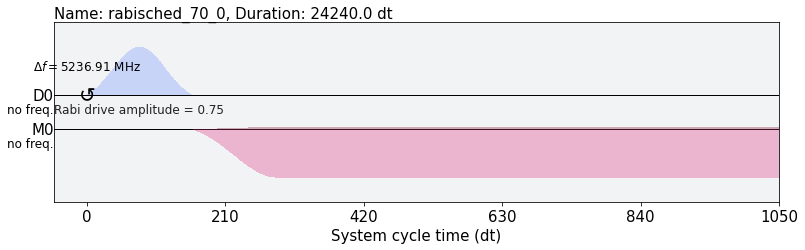

In [37]:
max_rabi_amp = 0.75
rabi_amps = helper.get_rabi_amps(max_rabi_amp)

rabi_scheds = []
for ridx, amp in enumerate(rabi_amps):
    with pulse.build(name="rabisched_%d_0" % ridx) as sched: # '0' corresponds to Rabi
        with pulse.align_sequential():
            pulse.set_frequency(f01*GHz, DriveChannel(qubit))
            rabi_pulse = Gaussian(duration=drive_duration, amp=amp, \
                              sigma=drive_sigma, name=f"Rabi drive amplitude = {amp}")
            pulse.play(rabi_pulse, DriveChannel(qubit))
            pulse.call(meas)
    rabi_scheds.append(sched)

# Draw rabi schedule
rabi_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [38]:
# Run the job on a real device
rabi_job = backend.run(rabi_scheds, job_name="Rabi", **helper.job_params)

print(rabi_job.job_id())
job_monitor(rabi_job)

# If the queuing time is too long, you can save the job id 
# And retrieve the job after it's done
# Replace 'JOB_ID' with the the your job id and uncomment to line below
#rabi_job = backend.retrieve_job('JOB_ID')

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60af8665d3cf25050944c0e4
Job Status: job has successfully run


### Fit the Rabi Data

We will fit the Rabi signal to a sinusoidal function of the form

$$ a \cos(2\pi f x + \phi) + c $$

to find the Rabi period $T = 2\pi/f$ with these fitting parameters:


Parameter | Corresponds to
 --- | ---
 $a$ | amplitude
 $f$ | Rabi drive frequency
 $\phi$ | phase offset
 $c$ | offset


We will use the `RabiFitter` from the `qiskit.ignis.characterization.calibration.fitters` library.

<div class="alert alert-block alert-danger">

**Note:** You may need to modify the fitting parameters below to get a good fit.

</div>

Pi amplitude is 0.205


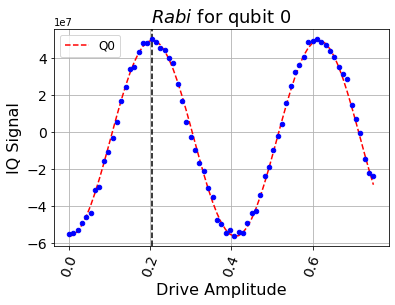

In [39]:
from qiskit.ignis.characterization.calibrations.fitters import RabiFitter

amp_guess = 5e7
fRabi_guess = 2
phi_guess = 0.5
c_guess = 0
fit_guess = [amp_guess, fRabi_guess, phi_guess, c_guess]

fit = RabiFitter(rabi_job.result(), rabi_amps, qubits=[qubit], fit_p0=fit_guess)
fit.plot(qind=0, series='0')
x180_amp = fit.pi_amplitude()
print("Pi amplitude is %.3f" % x180_amp)

#### --------------------------------------------------------------------------------------------------------------------

### 3. |1> - |2>

In [40]:
# Define pi pulse
x_pulse = Gaussian(duration=drive_duration,
                     amp=x180_amp, 
                     sigma=drive_sigma,
                     name='x_pulse')

def build_spec12_pulse_schedule(freq, anharm_guess_GHz):    
    with pulse.build(name="Spec Pulse at %.3f GHz" % (freq+anharm_guess_GHz)) as spec12_schedule:
        with pulse.align_sequential():            
            # WRITE YOUR CODE BETWEEN THESE LINES - START
            pulse.set_frequency(freq*GHz, DriveChannel(qubit))
            pulse.play(x_pulse, DriveChannel(qubit))
            pulse.set_frequency(freq*1.5*GHz, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(meas)
            
            # WRITE YOUR CODE BETWEEN THESE LINES - END
    return spec12_schedule

[5.08690961 5.09119533 5.09548104 5.09976676 5.10405247 5.10833819
 5.1126239  5.11690961 5.12119533 5.12548104 5.12976676 5.13405247
 5.13833819 5.1426239  5.14690961 5.15119533 5.15548104 5.15976676
 5.16405247 5.16833819 5.1726239  5.17690961 5.18119533 5.18548104
 5.18976676 5.19405247 5.19833819 5.2026239  5.20690961 5.21119533
 5.21548104 5.21976676 5.22405247 5.22833819 5.2326239  5.23690961
 5.24119533 5.24548104 5.24976676 5.25405247 5.25833819 5.2626239
 5.26690961 5.27119533 5.27548104 5.27976676 5.28405247 5.28833819
 5.2926239  5.29690961 5.30119533 5.30548104 5.30976676 5.31405247
 5.31833819 5.3226239  5.32690961 5.33119533 5.33548104 5.33976676
 5.34405247 5.34833819 5.3526239  5.35690961 5.36119533 5.36548104
 5.36976676 5.37405247 5.37833819 5.3826239  5.38690961]


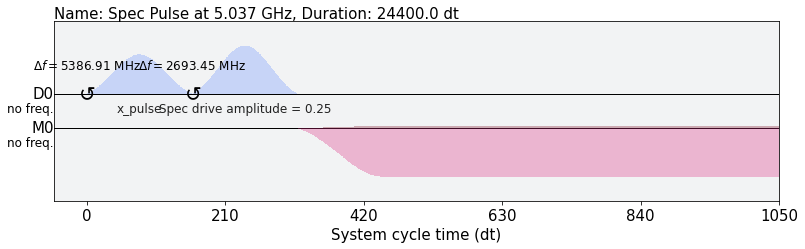

In [41]:
anharmonicity_guess_GHz = -0.35 # your anharmonicity guess
freqs_GHz = helper.get_spec12_freqs(f01, qubit)
print(freqs_GHz)
# Now vary the sideband frequency for each spec pulse
spec12_scheds = []
for freq in freqs_GHz:
    spec12_scheds.append(build_spec12_pulse_schedule(freq, anharmonicity_guess_GHz))

# Draw spec12 schedule   
spec12_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

### 4. Backend

In [42]:
# Run the job on a real device
spec12_job = backend.run(spec12_scheds, job_name="Spec 12", **helper.job_params)

print(spec12_job.job_id())
job_monitor(spec12_job)

# If the queuing time is too long, you can save the job id 
# And retrieve the job after it's done
# Replace 'JOB_ID' with the the your job id and uncomment to line below
#spec12_job = backend.retrieve_job('JOB_ID')

/opt/conda/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60af86904e24278cb02caa6a
Job Status: job has successfully run


### Measurement

### Fit the Spectroscopy Data

<div id='fit-f12'></div>

We will again fit the spectroscopy signal to a Lorentzian function of the form

$$ \frac{AB}{\pi[(f-f_{12})^2 + B^2]} + C $$

to find the frequency of the $|1\rangle \to |2\rangle$ transition $f_{12}$ with these fitting parameters:

Parameter | Corresponds to
 --- | ---
 $A$ | amplitude
 $f_{12}$ | 12 frequency guess (GHz)
 $B$ | scale
 $C$ | offset
 
 
<div class="alert alert-block alert-danger">

**Note:** You may need to modify the fitting parameters below to get a good fit.

</div>

Spec12 frequency is 4.886899 GHz


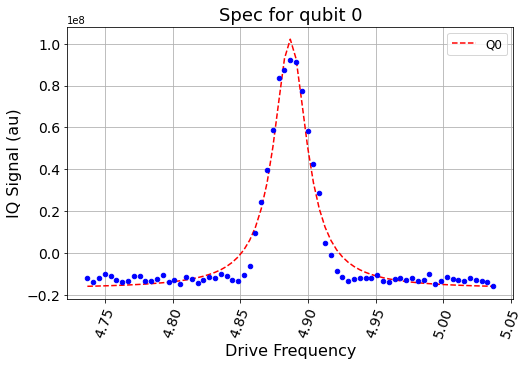

In [43]:
amp_guess = 2e7 #2e7
f12_guess = f01 - 0.2 #0.2
B = 0.1 #0.1
C = 0
fit_guess = [amp_guess, f12_guess, B, C]

fit = SpecFitter(spec12_job.result(), freqs_GHz+anharmonicity_guess_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f12 = fit.spec_freq(0, series='z')
print("Spec12 frequency is %.6f GHz" % f12)

Spec12 frequency is 4.886899 GHz


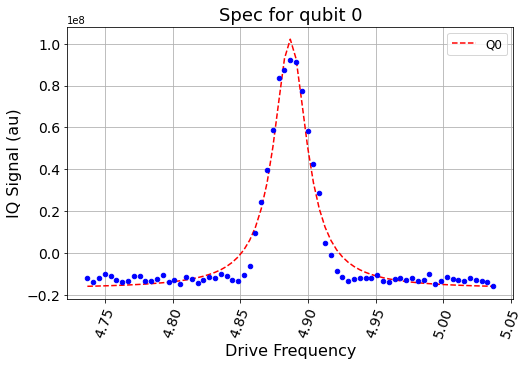

In [44]:
amp_guess = 2e7 #2e7
f12_guess = f01 - 0.2 #0.2
B = 0.1 #0.1
C = 0
fit_guess = [amp_guess, f12_guess, B, C]

fit = SpecFitter(spec12_job.result(), freqs_GHz+anharmonicity_guess_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f12 = fit.spec_freq(0, series='z')
print("Spec12 frequency is %.6f GHz" % f12)

### 5. Grading

In [47]:
grade_ex4(f12,qubit,backend_name)

Grading your answer for ex4. Please wait...

Congratulations 🎉! Your answer is correct.
Feel free to submit your answer.

